<a href="https://colab.research.google.com/github/JuyoungYang/Practice/blob/main/Mall_Customers_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
from google.colab import files
uploaded = files.upload()

Saving Mall_Customers.csv to Mall_Customers.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [ ]:
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# 1. 데이터 로드 및 기본 탐색

In [ ]:
# 기본 정보 출력
print("데이터 shape:", df.shape)
print("\n처음 5개 행:")
print(df.head())
print("\n기술통계량:")
print(df.describe())
print("\n결측치 확인:")
print(df.isnull().sum())

데이터 shape: (200, 5)

처음 5개 행:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

기술통계량:
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000 

In [ ]:
# 성별 레이블 인코딩
le = LabelEncoder()
df['Gender_Encoded'] = le.fit_transform(df['Gender'])

In [ ]:
# 데이터 분포 시각화
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Age Distribution')

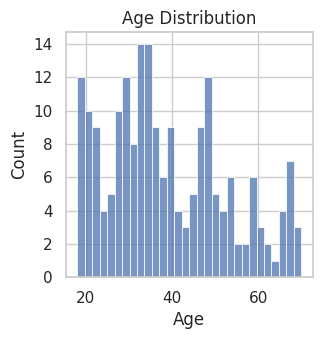

In [ ]:
# 나이 분포
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='Age', bins=30)
plt.title('Age Distribution')

Text(0.5, 1.0, 'Income Distribution by Gender')

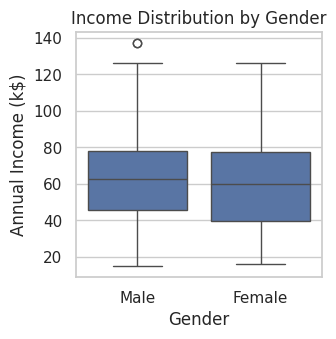

In [ ]:
# 성별에 따른 소득 분포
plt.subplot(2, 2, 2)
sns.boxplot(x='Gender', y='Annual Income (k$)', data=df)
plt.title('Income Distribution by Gender')

Text(0.5, 1.0, 'Income vs Spending Score')

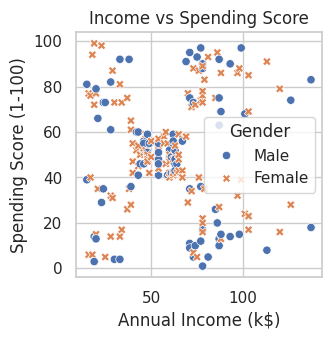

In [ ]:
# 소득과 소비 점수의 산점도
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
               hue='Gender', style='Gender')
plt.title('Income vs Spending Score')

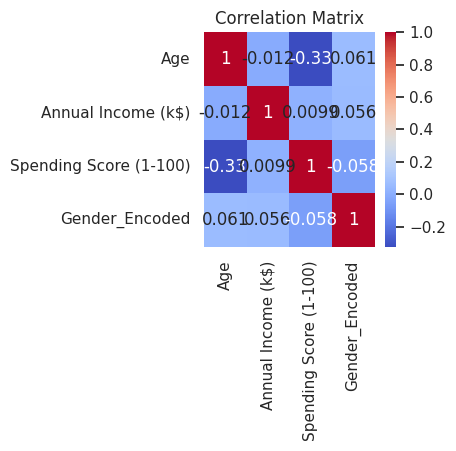

In [ ]:
# 상관관계 히트맵
plt.subplot(2, 2, 4)
numeric_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Encoded']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

# 2. 클러스터링 분석

In [ ]:
# 클러스터링을 위한 특성 선택 및 스케일링
features = ['Annual Income (k$)', 'Spending Score (1-100)']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

In [ ]:
# DBSCAN 클러스터링
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

In [ ]:
# GMM 클러스터링을 위한 최적 군집 수 찾기
n_components_range = range(2, 11)
bic = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_scaled)
    bic.append(gmm.bic(X_scaled))

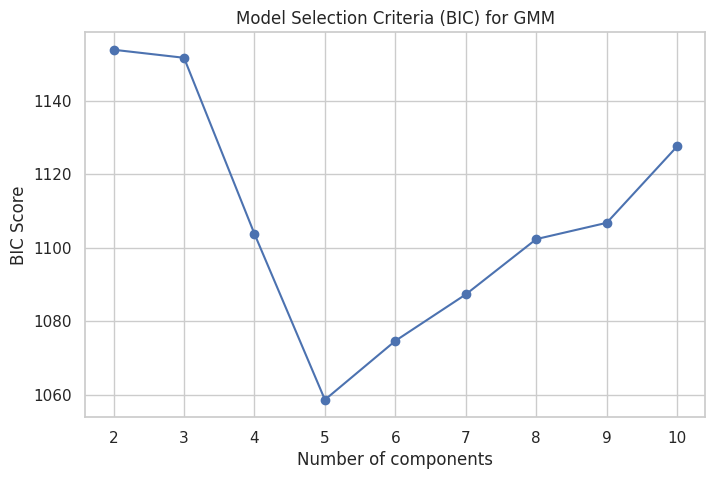

In [ ]:
# BIC 점수 시각화
plt.figure(figsize=(8, 5))
plt.plot(n_components_range, bic, marker='o')
plt.xlabel('Number of components')
plt.ylabel('BIC Score')
plt.title('Model Selection Criteria (BIC) for GMM')
plt.show()

In [ ]:
# 최적 군집 수로 GMM 수행
optimal_n_components = n_components_range[np.argmin(bic)]
print(f"최적 군집 수: {optimal_n_components}")

gmm = GaussianMixture(n_components=optimal_n_components, random_state=42)
df['GMM_Cluster'] = gmm.fit_predict(X_scaled)

최적 군집 수: 5


In [ ]:
# 클러스터링 결과 시각화
plt.figure(figsize=(15, 6))

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

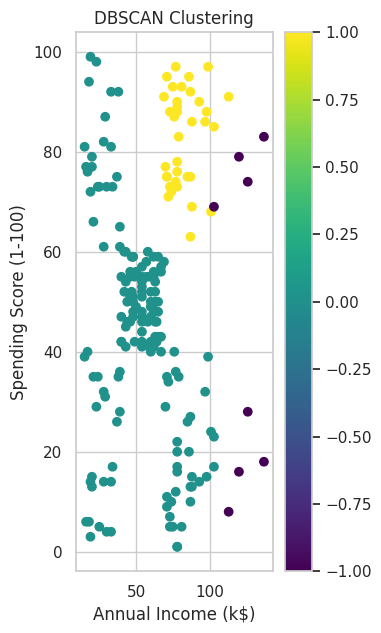

In [ ]:
# DBSCAN 결과
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'],
                      c=df['DBSCAN_Cluster'], cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.colorbar(scatter1)

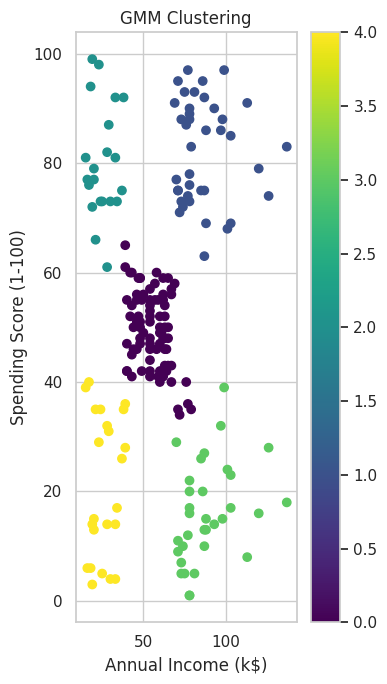

In [ ]:
# GMM 결과
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'],
                      c=df['GMM_Cluster'], cmap='viridis')
plt.title('GMM Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.colorbar(scatter2)

plt.tight_layout()
plt.show()

# 3. 고객 행동 예측 모델

In [ ]:
# Gender를 숫자로 인코딩
le = LabelEncoder()
df['Gender_Encoded'] = le.fit_transform(df['Gender'])

In [ ]:
# 고소비 고객 레이블 생성 (Spending Score 70 이상)
df['High_Spender'] = (df['Spending Score (1-100)'] >= 70).astype(int)

In [ ]:
# 예측을 위한 특성 준비
X = df[['Age', 'Gender_Encoded', 'Annual Income (k$)', 'GMM_Cluster']]
y = df['High_Spender']

In [ ]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# 모델 평가
y_pred = rf_model.predict(X_test)
print("\n분류 보고서:")
print(classification_report(y_test, y_pred))


분류 보고서:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        34
           1       0.86      1.00      0.92         6

    accuracy                           0.97        40
   macro avg       0.93      0.99      0.95        40
weighted avg       0.98      0.97      0.98        40



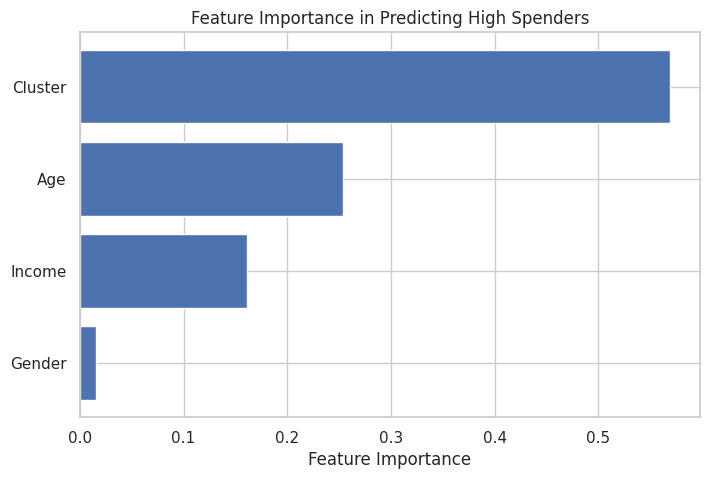

In [ ]:
# 특성 중요도 시각화
feature_importance = pd.DataFrame({
    'feature': ['Age', 'Gender', 'Income', 'Cluster'],
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Predicting High Spenders')
plt.show()

# 4. 클러스터별 특성 분석

In [ ]:
# 클러스터별 통계
cluster_stats = df.groupby('GMM_Cluster').agg({
    'Age': ['mean', 'std'],
    'Annual Income (k$)': ['mean', 'std'],
    'Spending Score (1-100)': ['mean', 'std'],
    'CustomerID': 'count'
}).round(2)

print("GMM 클러스터별 통계:")
print(cluster_stats)

GMM 클러스터별 통계:
               Age        Annual Income (k$)        Spending Score (1-100)  \
              mean    std               mean    std                   mean   
GMM_Cluster                                                                  
0            42.71  16.35              55.64   9.66                  49.37   
1            32.69   3.73              86.54  16.31                  82.13   
2            25.33   5.38              25.10   7.13                  80.05   
3            40.45  11.31              88.82  16.70                  16.00   
4            45.22  13.23              26.30   7.89                  20.91   

                   CustomerID  
               std      count  
GMM_Cluster                    
0             6.98         84  
1             9.36         39  
2            10.25         21  
3             9.10         33  
4            13.02         23  


In [ ]:
# 클러스터별 특성 시각화
plt.figure(figsize=(15, 12))

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

Text(0.5, 1.0, 'Age Distribution by Cluster')

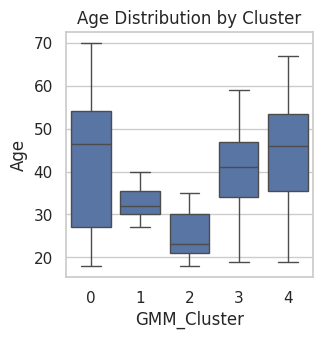

In [ ]:
# 나이 분포
plt.subplot(2, 2, 1)
sns.boxplot(x='GMM_Cluster', y='Age', data=df)
plt.title('Age Distribution by Cluster')

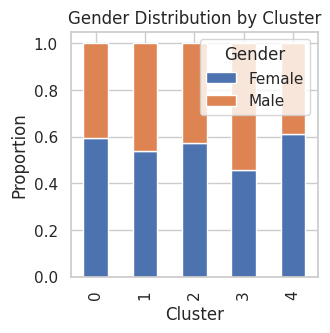

In [ ]:
# 성별 분포 시각화
plt.subplot(2, 2, 2)
# crosstab으로 각 클러스터별 성별 분포 계산
gender_dist = pd.crosstab(df['GMM_Cluster'], df['Gender'])
# 비율로 변환
gender_dist_pct = gender_dist.div(gender_dist.sum(axis=1), axis=0)
# 시각화
gender_dist_pct.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Gender Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Gender')

Text(0.5, 1.0, 'Income Distribution by Cluster')

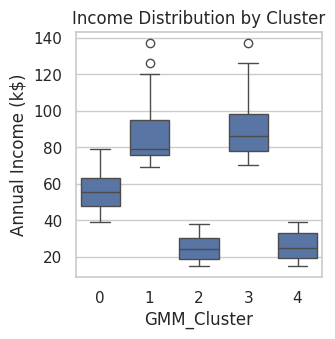

In [ ]:
# 소득 분포
plt.subplot(2, 2, 3)
sns.boxplot(x='GMM_Cluster', y='Annual Income (k$)', data=df)
plt.title('Income Distribution by Cluster')

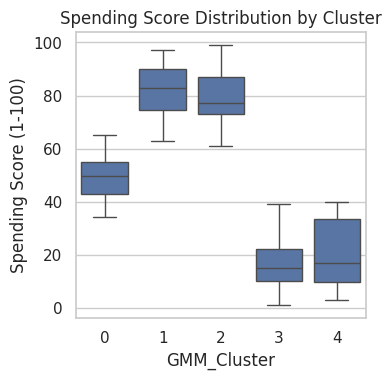

In [ ]:
# 소비 점수 분포
plt.subplot(2, 2, 4)
sns.boxplot(x='GMM_Cluster', y='Spending Score (1-100)', data=df)
plt.title('Spending Score Distribution by Cluster')

plt.tight_layout()
plt.show()

# 분석완료!

In [ ]:
# 클러스터별 주요 특성 출력
for cluster in sorted(df['GMM_Cluster'].unique()):
    cluster_data = df[df['GMM_Cluster'] == cluster]
    print(f"\n클러스터 {cluster} 특성:")
    print(f"고객 수: {len(cluster_data)} ({len(cluster_data)/len(df)*100:.1f}%)")
    print(f"평균 연령: {cluster_data['Age'].mean():.1f}세")
    print(f"평균 소득: ${cluster_data['Annual Income (k$)'].mean():.1f}k")
    print(f"평균 소비 점수: {cluster_data['Spending Score (1-100)'].mean():.1f}")
    print(f"성별 비율:\n{cluster_data['Gender'].value_counts(normalize=True)}")


클러스터 0 특성:
고객 수: 84 (42.0%)
평균 연령: 42.7세
평균 소득: $55.6k
평균 소비 점수: 49.4
성별 비율:
Gender
Female    0.595238
Male      0.404762
Name: proportion, dtype: float64

클러스터 1 특성:
고객 수: 39 (19.5%)
평균 연령: 32.7세
평균 소득: $86.5k
평균 소비 점수: 82.1
성별 비율:
Gender
Female    0.538462
Male      0.461538
Name: proportion, dtype: float64

클러스터 2 특성:
고객 수: 21 (10.5%)
평균 연령: 25.3세
평균 소득: $25.1k
평균 소비 점수: 80.0
성별 비율:
Gender
Female    0.571429
Male      0.428571
Name: proportion, dtype: float64

클러스터 3 특성:
고객 수: 33 (16.5%)
평균 연령: 40.5세
평균 소득: $88.8k
평균 소비 점수: 16.0
성별 비율:
Gender
Male      0.545455
Female    0.454545
Name: proportion, dtype: float64

클러스터 4 특성:
고객 수: 23 (11.5%)
평균 연령: 45.2세
평균 소득: $26.3k
평균 소비 점수: 20.9
성별 비율:
Gender
Female    0.608696
Male      0.391304
Name: proportion, dtype: float64
